# 규제 선형 모델(Regularized Linear Models)

## 규제 선형 모델
: 회귀 계수가 기하급수적으로 커지는 것을 제어

## 릿지 회귀(Ridge Regression)
- L2 Norm
- 다중공선성이 높은 상황에서 좋은 예측 성능
- 회귀계수의 크기가 큰 변수를 우선적으로 줄이는 경향
- 변수 선택 불가능
- 제약 범위가 원의 형태
- 회귀 계수를 작게 만들긴 하지만 0으로 만들지는 않음

### 목적 함수
- $\text{min}(\text{RSS}(W)+\alpha \cdot ||W||^2_2)$
    - $W = (w_0, w_1, ..., w_n)$
    - $||W||_2 = \sqrt {w_0^2+w_1^2+...+w_n^2}$

In [1]:
from sklearn.datasets import load_boston
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
import numpy as np
import pandas as pd

boston = load_boston()
bostonDF = pd.DataFrame(data=boston.data, columns=boston.feature_names)
bostonDF['PRICE'] = boston.target

y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'], axis=1)

In [2]:
# 릿지 회귀로 예측, 성능 평가
ridge = Ridge(alpha = 10)
neg_mse_scores = cross_val_score(ridge, X_data, y_target,
                                scoring='neg_mean_squared_error', cv=5)
rmse_scores = np.sqrt(-1*neg_mse_scores)
avg_rmse = np.mean(rmse_scores)
print('5 folds의 개별 MSE scores:', np.round(-1*neg_mse_scores, 3))
print('5 folds의 개별 RMSE scores:', np.round(rmse_scores, 3))
print('5 folds의 평균 RMSE score:', np.round(avg_rmse, 3))

5 folds의 개별 MSE scores: [11.422 24.294 28.144 74.599 28.517]
5 folds의 개별 RMSE scores: [3.38  4.929 5.305 8.637 5.34 ]
5 folds의 평균 RMSE score: 5.518


### alpha 변경

In [3]:
# alpha=0일 때는 LinearRegression과 동일한 결과
alphas = [0, 0.1, 1, 10, 100]

for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    
    neg_mse_scores = cross_val_score(ridge, X_data, y_target,
                                    scoring='neg_mean_squared_error', cv=5)
    rmse_scores = np.sqrt(-1*neg_mse_scores)
    avg_rmse = np.mean(rmse_scores)
    print(f'alpha {alpha}일 때 5 folds의 평균 RMSE : {avg_rmse:.3f}')

alpha 0일 때 5 folds의 평균 RMSE : 5.829
alpha 0.1일 때 5 folds의 평균 RMSE : 5.788
alpha 1일 때 5 folds의 평균 RMSE : 5.653
alpha 10일 때 5 folds의 평균 RMSE : 5.518
alpha 100일 때 5 folds의 평균 RMSE : 5.330


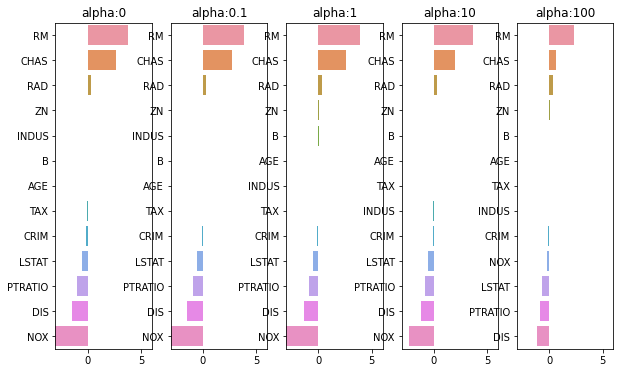

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(figsize=(10, 6), nrows=1, ncols=5)
coeff_df = pd.DataFrame()

for pos, alpha in enumerate(alphas):
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_data, y_target)
    
    coeff = pd.Series(data=ridge.coef_, index=X_data.columns)
    colname = 'alpha:'+str(alpha)
    coeff_df[colname] = coeff
    
    coeff = coeff.sort_values(ascending=False)
    axs[pos].set_title(colname)
    axs[pos].set_xlim(-3, 6)
    sns.barplot(x=coeff.values, y=coeff.index, ax=axs[pos])

In [6]:
coeff_df.sort_values(by='alpha:0', ascending=False)

,alpha:0,alpha:0.1,alpha:1,alpha:10,alpha:100
RM,3.809865,3.818233,3.854000,3.702272,2.334536
CHAS,2.686734,2.670019,2.552393,1.952021,0.638335
RAD,0.306049,0.303515,0.290142,0.279596,0.315358
ZN,0.046420,0.046572,0.047443,0.049579,0.054496
INDUS,0.020559,0.015999,-0.008805,-0.042962,-0.052826
B,0.009312,0.009368,0.009673,0.010037,0.009393
AGE,0.000692,-0.000269,-0.005415,-0.010707,0.001212
TAX,-0.012335,-0.012421,-0.012912,-0.013993,-0.015856
CRIM,-0.108011,-0.107474,-0.104595,-0.101435,-0.102202
LSTAT,-0.524758,-0.525966,-0.533343,-0.559366,-0.660764


## 라쏘 회귀(Lasso Regression)
- L1 Norm
- 제약 범위가 각진 형태
- 회귀계수 일부가 0이 되어 변수 선택 기법으로 활용
- 다중공선성이 높은 상황에서 Ridge에 비해 예측 성능이 떨어짐

### 목적 함수
- $\text{min}(\text{RSS}(W)+\alpha \cdot ||W||_1)$
    - $W = (w_0, w_1, ..., w_n)$
    - $||W||_1 = |w_0|+|w_1|+...+|w_n|$

In [9]:
from sklearn.linear_model import Lasso, ElasticNet

def get_linear_reg_eval(model_name, params=None, X_data_n=None,
                       y_target_n=None, verbose=True, return_coeff=True):
    coeff_df = pd.DataFrame()
    if verbose: print('######', model_name, '######')
    for param in params:
        if model_name == 'Ridge' : model = Ridge(alpha=param)
        elif model_name == 'Lasso' : model = Lasso(alpha=param)
        elif model_name == 'ElasticNet' : model = ElasticNet(alpha=param, l1_ratio=0.7)
        neg_mse_scores = cross_val_score(model, X_data_n, y_target_n,
                                        scoring='neg_mean_squared_error', cv=5)
        rmse_scores = np.sqrt(-1*neg_mse_scores)
        avg_rmse = np.mean(rmse_scores)
        print(f'alpha {alpha}일 때 5 folds의 평균 RMSE : {avg_rmse:.3f}')
        
        model.fit(X_data_n, y_target_n)
        
        if return_coeff:
            coeff = pd.Series(data=model.coef_, index=X_data_n.columns)
            colname = 'alpha:'+str(param)
            coeff_df[colname] = coeff
            
    return coeff_df

In [10]:
lasso_alphas = [0.07, 0.1, 0.5, 1, 3]
coeff_lasso_df = get_linear_reg_eval('Lasso', lasso_alphas, X_data, y_target)

###### Lasso ######
alpha 100일 때 5 folds의 평균 RMSE : 5.612
alpha 100일 때 5 folds의 평균 RMSE : 5.615
alpha 100일 때 5 folds의 평균 RMSE : 5.669
alpha 100일 때 5 folds의 평균 RMSE : 5.776
alpha 100일 때 5 folds의 평균 RMSE : 6.189


In [12]:
coeff_lasso_df.sort_values(by='alpha:'+str(lasso_alphas[0]), ascending=False)

,alpha:0.07,alpha:0.1,alpha:0.5,alpha:1,alpha:3
RM,3.789725,3.703202,2.498212,0.949811,0.000000
CHAS,1.434343,0.955190,0.000000,0.000000,0.000000
RAD,0.270936,0.274707,0.277451,0.264206,0.061864
ZN,0.049059,0.049211,0.049544,0.049165,0.037231
B,0.010248,0.010249,0.009469,0.008247,0.006510
NOX,-0.000000,-0.000000,-0.000000,-0.000000,0.000000
AGE,-0.011706,-0.010037,0.003604,0.020910,0.042495
TAX,-0.014290,-0.014570,-0.015442,-0.015212,-0.008602
INDUS,-0.042120,-0.036619,-0.005253,-0.000000,-0.000000
CRIM,-0.098193,-0.097894,-0.083289,-0.063437,-0.000000


## 엘라스틱넷 회귀(ElasticNet Regression)
- L1 + L2 Norm
- 상대적으로 시간이 오래 걸림

### 목적 함수
- $\text{min}(\text{RSS}(W)+\alpha_1 \cdot ||W||_1+\alpha_2 \cdot ||W||_2^2)$
    - $W = (w_0, w_1, ..., w_n)$

### 사이킷런에서
- `ElasticNet(alpha, l1_ratio)`
    - `alpha` : 목적 함수에서의 $\alpha_1+\alpha_2$
    - `l1_ratio` : 목적 함수에서의 $\dfrac{\alpha_1} {\alpha_1+\alpha_2}$
        - 0이면 $\alpha_1=0$이므로 L2와 동일
        - 1이면 $\alpha_2=0$이므로 L1과 동일

In [13]:
elastic_alphas = [0.07, 0.1, 0.5, 1, 3]
coeff_elastic_df = get_linear_reg_eval('ElasticNet', elastic_alphas, X_data, y_target)

###### ElasticNet ######
alpha 100일 때 5 folds의 평균 RMSE : 5.542
alpha 100일 때 5 folds의 평균 RMSE : 5.526
alpha 100일 때 5 folds의 평균 RMSE : 5.467
alpha 100일 때 5 folds의 평균 RMSE : 5.597
alpha 100일 때 5 folds의 평균 RMSE : 6.068


In [14]:
coeff_elastic_df.sort_values(by='alpha:'+str(elastic_alphas[0]), ascending=False)

,alpha:0.07,alpha:0.1,alpha:0.5,alpha:1,alpha:3
RM,3.574162,3.414154,1.918419,0.938789,0.000000
CHAS,1.330724,0.979706,0.000000,0.000000,0.000000
RAD,0.278880,0.283443,0.300761,0.289299,0.146846
ZN,0.050107,0.050617,0.052878,0.052136,0.038268
B,0.010122,0.010067,0.009114,0.008320,0.007020
AGE,-0.010116,-0.008276,0.007760,0.020348,0.043446
TAX,-0.014522,-0.014814,-0.016046,-0.016218,-0.011417
INDUS,-0.044855,-0.042719,-0.023252,-0.000000,-0.000000
CRIM,-0.099468,-0.099213,-0.089070,-0.073577,-0.019058
NOX,-0.175072,-0.000000,-0.000000,-0.000000,-0.000000


In [15]:
scale_methods=[(None, None), ('Standard', None), ('Standard', 2), 
               ('MinMax', None), ('MinMax', 2), ('Log', None)]

for scale_method in scale_methods:
    X_data_scaled = get_scaled_data(method=scale_method[0], p_degree=scale_method[1], 
                                    input_data=X_data)
    print(X_data_scaled.shape, X_data.shape)
    print('\n## 변환 유형:{0}, Polynomial Degree:{1}'.format(scale_method[0], scale_method[1]))
    get_linear_reg_eval('Ridge', params=alphas, X_data_n=X_data_scaled, 
                        y_target_n=y_target, verbose=False, return_coeff=False)


NameError: name 'get_scaled_data' is not defined